# **Importing all required Packages**

In [2]:
!pip install pyod

In [3]:
pip install dtaidistance

     |████████████████████████████████| 1.1 MB 31.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for dtaidistance: filename=dtaidistance-2.3.2-cp37-cp37m-linux_x86_64.whl size=1586354 sha256=3db367c6bcf3d3ee8d0e564104ddc96fa1e1cc7adb50203123b5a3e2e7fca987
  Stored in directory: /root/.cache/pip/wheels/5e/4a/9a/30f9efb3926e3c2f28231680685b36d0041466a33e4b8f8367
Successfully built dtaidistance


In [4]:
! pip install anomatools

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from anomatools.models import iNNE
from pyod.models.cblof import CBLOF

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv('DSL-StrongPasswordData.csv')
df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,DD.e.five,UD.e.five,H.five,DD.five.Shift.r,UD.five.Shift.r,H.Shift.r,DD.Shift.r.o,UD.Shift.r.o,H.o,DD.o.a,UD.o.a,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,0.2212,0.1043,0.1417,1.1885,1.0468,0.1146,1.6055,1.4909,0.1067,0.7590,0.6523,0.1016,0.2136,0.1120,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,0.1357,0.0449,0.0829,1.1970,1.1141,0.0689,0.7822,0.7133,0.1570,0.7877,0.6307,0.1066,0.1684,0.0618,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,0.1542,0.0721,0.0808,1.0408,0.9600,0.0892,0.6203,0.5311,0.1454,0.7195,0.5741,0.1365,0.2931,0.1566,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,0.2038,0.0998,0.0900,1.0556,0.9656,0.0913,1.2564,1.1651,0.1454,0.7550,0.6096,0.0956,0.1530,0.0574,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,0.1589,0.0686,0.0805,0.8629,0.7824,0.0742,0.8955,0.8213,0.1243,0.7632,0.6389,0.0430,0.1975,0.1545,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


In [9]:
subjects = df["subject"].unique()

# **Calculating Most Frequent Values**

In [10]:
def most_frequent( List):
    # print( set(  List  ))
    # print( List.count   ) )
    return max( set(List), key = List.count)

In [11]:
def Compute_Predicted_Labels( y_true , y_pred ):
  predicted_labels = [  ] 

  for x in range(len(y_true)) :
    if (y_true[ x ] == y_pred[ x ]) :
      predicted_labels.append( 1 )      #####      Normals 
    else:
      predicted_labels.append( 0 )      #####    outliers
        
  return predicted_labels

# Nearest-neighbor based on Mahalanobis distance

In [30]:
nb_h_accuracies = []
nb_h_eers = []
nb_h_scores = []

Predicted_labels_All_Mahalanobis = [  ] 


for subject in subjects:           
  # Consider current subject as genuine and rest as imposters
  # !!!!!!!!!!!!!!!!!!!!!!! to be seen the df  whether it will be 51 or not
  genuine_df = df.loc[df.subject == subject, "H.period":"H.Return"]
  imposter_df = df.loc[df.subject != subject, :]
  
  genuine_df = genuine_df.reset_index()
  imposter_df = imposter_df.reset_index() 

 
  train = genuine_df[200:]
  train.drop('index', axis=1, inplace=True)


  # True set (200 records)
  test_genuine = genuine_df[:200]
  test_genuine = test_genuine.reset_index()

  test_genuine.drop('level_0', axis=1, inplace=True)
  test_genuine.drop('index', axis=1, inplace=True)
    
    
  # False set (200 records, 4 per imposter, 50 imposters in all)
  test_imposter = imposter_df.groupby("subject").head(4).loc[:, "H.period":"H.Return"]
  test_imposter = test_imposter.reset_index()
  test_imposter.drop('index', axis=1, inplace=True)

  data = test_genuine.append(test_imposter, ignore_index=True)

  # y_true
  y_true = [0]*len(test_genuine) + [-1]*len(test_imposter)
  #metric='mahalanobis', metric_params={'VI': np.linalg.inv(np.cov(train.values))


  nb_h = NearestNeighbors(algorithm='ball_tree', leaf_size= 34, n_neighbors=20, radius=0)
  nb_h.fit(train.values) 
  # data => test data
  distances, indeces = nb_h.kneighbors(data.values, n_neighbors=1)
  nb_h_scores.append(distances)

  th=np.mean(distances)
  nb_h_outlier_index = np.where(distances.mean(axis = 1) > th ) # index of outliers 
  nb_h_outlier_values = data.iloc[nb_h_outlier_index]

  y_pred = []
  for i in range(len(data)):
    if (i in nb_h_outlier_index[0]):
      y_pred.append(-1)
    else:
      y_pred.append(0)
  
  Predicted_labels_All_Mahalanobis.append(  Compute_Predicted_Labels(  y_true , y_pred  ) )
  
  nb_h_accuracies.append(accuracy_score(y_true, y_pred))

  fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label=0)
  fnr = 1 - tpr
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
  nb_h_eers.append(eer)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.p

In [31]:
print(  len( Predicted_labels_All_Mahalanobis )   )
print(  len ( Predicted_labels_All_Mahalanobis[0] )   )

51
400


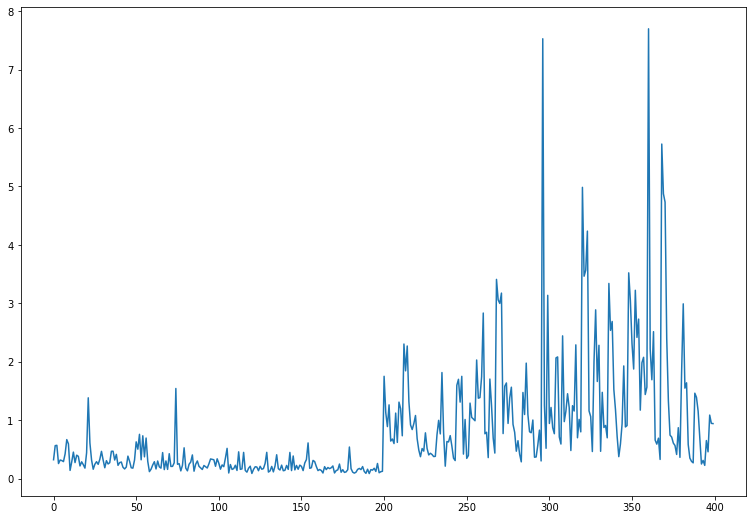

In [32]:
# plot mean of distances for each observation
plt.plot(distances.mean(axis =1))

In [33]:
nb_h_accuracies

[0.7275,
 0.81,
 0.765,
 0.7375,
 0.8325,
 0.795,
 0.83,
 0.8175,
 0.7825,
 0.8325,
 0.785,
 0.5875,
 0.8125,
 0.78,
 0.75,
 0.73,
 0.775,
 0.5175,
 0.725,
 0.7475,
 0.805,
 0.735,
 0.8,
 0.83,
 0.71,
 0.715,
 0.75,
 0.61,
 0.7475,
 0.7625,
 0.61,
 0.77,
 0.6825,
 0.77,
 0.635,
 0.7675,
 0.78,
 0.625,
 0.695,
 0.68,
 0.6225,
 0.7925,
 0.395,
 0.7775,
 0.8075,
 0.7775,
 0.82,
 0.7825,
 0.8625,
 0.79,
 0.795]

In [34]:
Mean_Accu_Neighbor_Mahalobis = np.mean(nb_h_accuracies)
print( Mean_Accu_Neighbor_Mahalobis )

0.7420098039215685


In [35]:
Mean_EER_Neighbor_Mahalobis = np.mean(nb_h_eers)
print(   Mean_EER_Neighbor_Mahalobis )

0.4367647058823529


In [36]:
len(distances)

400

# Nearest-neighbor based on Manhattan distance

In [37]:
nb_m_accuracies = []
nb_m_eers = []
nb_m_scores = []

Predicted_labels_All_Manhattan = []

for subject in subjects:           
  # Consider current subject as genuine and rest as imposters
  genuine_df = df.loc[df.subject == subject, "H.period":"H.Return"]
  imposter_df = df.loc[df.subject != subject, :]
  
  genuine_df = genuine_df.reset_index()
  imposter_df = imposter_df.reset_index() 

  train = genuine_df[200:]
  train.drop('index', axis=1, inplace=True)

  # True set (100 records)
  test_genuine = genuine_df[:200]
  test_genuine = test_genuine.reset_index()
  test_genuine.drop('level_0', axis=1, inplace=True)
  test_genuine.drop('index', axis=1, inplace=True)
    
    
  # False set (250 records, 5 per imposter, 50 imposters in all)
  test_imposter = imposter_df.groupby("subject").head(4).loc[:, "H.period":"H.Return"]
  test_imposter = test_imposter.reset_index()
  test_imposter.drop('index', axis=1, inplace=True)

  data = test_genuine.append(test_imposter, ignore_index=True)

  # y_true
  y_true = [0]*len(test_genuine) + [-1]*len(test_imposter)

  nb_m = NearestNeighbors(n_neighbors = 5, metric='manhattan')
  nb_m.fit(train.values)
  distances, indeces = nb_m.kneighbors(data.values, n_neighbors=1)
  nb_m_scores.append(distances)

  th=np.mean(distances)
  nb_m_outlier_index = np.where(distances.mean(axis = 1) > th)
  nb_m_outlier_values = data.iloc[nb_m_outlier_index]

  y_pred = []
  for i in range(len(data)):
    if (i in nb_m_outlier_index[0]):
      y_pred.append(-1)
    else:
      y_pred.append(0)
  
  nb_m_accuracies.append(accuracy_score(y_true, y_pred))

  Predicted_labels_All_Manhattan.append(  Compute_Predicted_Labels(  y_true , y_pred  ) )
  
  
  fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label=0)
  fnr = 1 - tpr
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
  nb_m_eers.append(eer)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.p

In [38]:
nb_m_accuracies

[0.74,
 0.815,
 0.795,
 0.74,
 0.83,
 0.815,
 0.8425,
 0.8375,
 0.805,
 0.845,
 0.8,
 0.6175,
 0.8225,
 0.7975,
 0.7725,
 0.7375,
 0.7825,
 0.655,
 0.7425,
 0.7725,
 0.7925,
 0.765,
 0.825,
 0.8475,
 0.755,
 0.72,
 0.7775,
 0.6525,
 0.76,
 0.765,
 0.7525,
 0.7775,
 0.7125,
 0.775,
 0.6575,
 0.795,
 0.8,
 0.6625,
 0.72,
 0.6825,
 0.645,
 0.8125,
 0.425,
 0.7975,
 0.8075,
 0.815,
 0.8275,
 0.795,
 0.87,
 0.8,
 0.8125]

In [39]:
Mean_Accu_Neighbor_Manhattan = np.mean( nb_m_accuracies )

print( Mean_Accu_Neighbor_Manhattan )


0.7640686274509803


In [40]:
nb_m_eers

[0.465,
 0.345,
 0.395,
 0.455,
 0.31,
 0.36,
 0.315,
 0.31,
 0.37,
 0.31,
 0.385,
 0.6,
 0.34,
 0.36,
 0.41,
 0.415,
 0.395,
 0.45,
 0.47,
 0.42,
 0.4,
 0.43,
 0.345,
 0.3,
 0.44,
 0.475,
 0.405,
 0.55,
 0.415,
 0.405,
 0.26,
 0.415,
 0.47,
 0.395,
 0.545,
 0.365,
 0.365,
 0.53,
 0.445,
 0.495,
 0.545,
 0.37,
 0.78,
 0.385,
 0.375,
 0.33,
 0.34,
 0.38,
 0.26,
 0.385,
 0.365]

In [41]:
Mean_EER_Neighbor_Manhattan = np.mean( nb_m_eers )

print( Mean_EER_Neighbor_Manhattan )


0.40872549019607846


In [42]:
np.mean(nb_m_accuracies)

0.7640686274509803

In [43]:
np.mean(nb_m_eers)

0.40872549019607846

In [44]:
len(nb_m_scores)

51

# DBSCAN

In [45]:
# https://towardsdatascience.com/multivariate-outlier-detection-in-python-e946cfc843b3
Predicted_labels_All_DBSCAN = [  ] 

DBSCAN_accuracies = []
DBSCAN_eers = []
        
for subject in subjects:           
  # Consider current subject as genuine and rest as imposters
  genuine_df = df.loc[df.subject == subject, "H.period":"H.Return"]
  imposter_df = df.loc[df.subject != subject, :]
  
  genuine_df = genuine_df.reset_index()
  imposter_df = imposter_df.reset_index() 
  
  # True set (100 records)
  test_genuine = genuine_df[:200]
  test_genuine = test_genuine.reset_index()
  test_genuine.drop('level_0', axis=1, inplace=True)
  test_genuine.drop('index', axis=1, inplace=True)
    
    
  # False set (250 records, 5 per imposter, 50 imposters in all)
  test_imposter = imposter_df.groupby("subject").head(4).loc[:, "H.period":"H.Return"]
  test_imposter = test_imposter.reset_index()
  test_imposter.drop('index', axis=1, inplace=True)

  data = test_genuine.append(test_imposter, ignore_index=True)

  # y_true
  y_true = [0]*len(test_genuine) + [-1]*len(test_imposter)

  dbsc = DBSCAN(eps =0.5, min_samples = 10, algorithm='ball_tree',metric='euclidean') 
                #metric_params={'VI':np.cov(data.values)})  
  #eps= 0.85789474
  #eps = 0.1, min_samples = 2, metric='mahalanobis', 
  #metric_params={'VI':np.cov(data.values)}
  
  dbsc.fit(data.values)

  dbsc_outliers_values = data[dbsc.labels_ == -1]
  dbsc_outlier_index = np.where(dbsc.labels_ == -1) 

  # y_pred
  y_pred = [] 
  for i in range(len(data)):
    if (i in dbsc_outlier_index[0]):
      y_pred.append(-1)
    else:
      y_pred.append(0)
 
  Predicted_labels_All_DBSCAN.append(Compute_Predicted_Labels(y_true , y_pred))

  DBSCAN_accuracies.append(accuracy_score(y_true, dbsc.labels_))
  
  fpr, tpr, threshold = roc_curve(y_true, dbsc.labels_, pos_label=0)
  fnr = 1 - tpr
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
  DBSCAN_eers.append(eer)

In [46]:
print(  len (  Predicted_labels_All_DBSCAN ) )
print(  len (  Predicted_labels_All_DBSCAN[0] )  )

51
400


In [47]:
DBSCAN_accuracies

[0.74,
 0.775,
 0.765,
 0.73,
 0.7725,
 0.805,
 0.795,
 0.7975,
 0.7575,
 0.8025,
 0.785,
 0.61,
 0.795,
 0.7525,
 0.7475,
 0.68,
 0.76,
 0.5825,
 0.715,
 0.735,
 0.7875,
 0.7575,
 0.7775,
 0.8,
 0.7175,
 0.7175,
 0.7325,
 0.5575,
 0.735,
 0.7275,
 0.525,
 0.76,
 0.66,
 0.7575,
 0.59,
 0.725,
 0.7725,
 0.68,
 0.685,
 0.6675,
 0.65,
 0.795,
 0.4475,
 0.735,
 0.805,
 0.75,
 0.7975,
 0.76,
 0.8125,
 0.7825,
 0.7975]

In [48]:
np.mean(DBSCAN_accuracies)

0.7287745098039217

In [49]:
Mean_Acc_DBSCAN = np.mean(DBSCAN_accuracies)
print( Mean_Acc_DBSCAN )

0.7287745098039217


In [50]:
Mean_EER_DBSCAN = np.mean(  DBSCAN_eers )
print( Mean_EER_DBSCAN )

0.401078431372549


# Local outlier factor (LOF)

In [51]:
LOF = LocalOutlierFactor(algorithm= 'brute',leaf_size=17,n_neighbors=30,p= 3,contamination= 0.5)

#n_neighbors = 20, leaf_size=30, metric = "minkowski", contamination = 0.1, algorithm='auto')
#algorithm= 'brute',leaf_size=17,n_neighbors=30,p= 3,contamination= 0.32222222
LOF_eers = []
LOF_accuracies = []
LOF_scores = []

Predicted_labels_All_LOF = [  ]  

for subject in subjects:           
  # Consider current subject as genuine and rest as imposters
  genuine_df = df.loc[df.subject == subject, "H.period":"H.Return"]
  imposter_df = df.loc[df.subject != subject, :]
  
  genuine_df = genuine_df.reset_index()
  imposter_df = imposter_df.reset_index() 

  # True set (100 records)
  test_genuine = genuine_df[:200]
  test_genuine = test_genuine.reset_index()
  test_genuine.drop('level_0', axis=1, inplace=True)
  test_genuine.drop('index', axis=1, inplace=True)
    
    
  # False set (250 records, 5 per imposter, 50 imposters in all)
  test_imposter = imposter_df.groupby("subject").head(4).loc[:, "H.period":"H.Return"]
  test_imposter = test_imposter.reset_index()
  test_imposter.drop('index', axis=1, inplace=True)

  data = test_genuine.append(test_imposter, ignore_index=True)

  # y_true
  y_true = [1]*len(test_genuine) + [-1]*len(test_imposter)

  y_pred = LOF.fit_predict(data.values)

  LOF_outlier_index = np.where(y_pred == -1) 
  LOF_outlier_values = data.iloc[LOF_outlier_index]
  
  Predicted_labels_All_LOF.append(  Compute_Predicted_Labels(  y_true , y_pred  ) )

  LOF_accuracies.append(accuracy_score(y_true, y_pred))

  fpr, tpr, threshold = roc_curve(y_true, y_pred )
  fnr = 1 - tpr
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
  LOF_eers.append(eer)

  #The opposite LOF of the training samples. The higher, the more normal. Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), while outliers tend to have a larger LOF score.
  Anomaly_Score = LOF.negative_outlier_factor_
  LOF_scores.append(Anomaly_Score)

In [52]:
#The opposite LOF of the training samples. 
#The higher, the more normal. 
#Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), 
#while outliers tend to have a larger LOF score.
len(LOF_scores)

51

In [53]:
print( np.max(LOF_scores  ) ) 
print( np.min( LOF_scores )   )

-0.9534596508246345
-25.42924912416917


In [54]:
LOF_accuracies

[0.805,
 0.64,
 0.74,
 0.715,
 0.685,
 0.65,
 0.615,
 0.665,
 0.665,
 0.625,
 0.67,
 0.575,
 0.73,
 0.59,
 0.66,
 0.52,
 0.615,
 0.56,
 0.77,
 0.735,
 0.59,
 0.73,
 0.77,
 0.72,
 0.685,
 0.635,
 0.645,
 0.56,
 0.69,
 0.59,
 0.48,
 0.655,
 0.56,
 0.655,
 0.55,
 0.565,
 0.755,
 0.625,
 0.61,
 0.525,
 0.55,
 0.725,
 0.46,
 0.58,
 0.68,
 0.59,
 0.67,
 0.605,
 0.615,
 0.645,
 0.585]

In [55]:
Mean_acc_LOF = np.mean(LOF_accuracies)
print(  Mean_acc_LOF )

0.6378431372549018


In [56]:

Mean_ERR_LOF = np.mean(LOF_eers)
print(  Mean_ERR_LOF )


0.36215686274509806


# Cluster-based Local Outlier Factor (CBLOF)

In [57]:
CB_LOF = CBLOF(alpha= 0.5,beta=2,contamination= 0.27777778,n_clusters= 71,use_weights=False)
CB_LOF_eers = []
CB_LOF_accuracies = []
CB_LOF_scores = []    
Predicted_labels_All_CBLOF = [  ]

for subject in subjects:           
  # Consider current subject as genuine and rest as imposters
  genuine_df = df.loc[df.subject == subject, "H.period":"H.Return"]
  imposter_df = df.loc[df.subject != subject, :]
  
  genuine_df = genuine_df.reset_index()
  imposter_df = imposter_df.reset_index() 

  # True set (100 records)
  test_genuine = genuine_df[:200]
  test_genuine = test_genuine.reset_index()
  test_genuine.drop('level_0', axis=1, inplace=True)
  test_genuine.drop('index', axis=1, inplace=True)
  
  # False set (250 records, 5 per imposter, 50 imposters in all)
  test_imposter = imposter_df.groupby("subject").head(4).loc[:, "H.period":"H.Return"]
  test_imposter = test_imposter.reset_index()
  test_imposter.drop('index', axis=1, inplace=True)

  data = test_genuine.append(test_imposter, ignore_index=True)

  # y_true
  y_true = [0]*len(test_genuine) + [1]*len(test_imposter)
  y_pred = CB_LOF.fit_predict(data.values)

  CB_LOF_outlier_index = np.where(y_pred == -1) 
  CB_LOF_outlier_values = data.iloc[CB_LOF_outlier_index]
  
  Predicted_labels_All_CBLOF.append(  Compute_Predicted_Labels(  y_true , y_pred  ) )

  CB_LOF_accuracies.append(accuracy_score(y_true, y_pred))

  fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label=0)
  fnr = 1 - tpr
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
  CB_LOF_eers.append(eer)

  Anomaly_Score = CB_LOF.decision_function(data.values)
  CB_LOF_scores.append(Anomaly_Score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning

In [58]:
print( np.max(CB_LOF_scores )   ) 
print( np.min( CB_LOF_scores )  )

35.28538572890734
0.049348140660577085


In [59]:
CB_LOF_accuracies

[0.6975,
 0.6875,
 0.6975,
 0.7075,
 0.7225,
 0.7225,
 0.7175,
 0.7225,
 0.7275,
 0.7175,
 0.7125,
 0.6225,
 0.7575,
 0.7025,
 0.6825,
 0.6525,
 0.7025,
 0.5875,
 0.6975,
 0.6875,
 0.6925,
 0.6825,
 0.7375,
 0.7225,
 0.6825,
 0.6625,
 0.6825,
 0.5775,
 0.7025,
 0.6975,
 0.5325,
 0.7125,
 0.6575,
 0.7025,
 0.5925,
 0.6675,
 0.7175,
 0.6325,
 0.6375,
 0.6325,
 0.6375,
 0.7325,
 0.4975,
 0.6725,
 0.7175,
 0.6875,
 0.7175,
 0.7125,
 0.7425,
 0.7225,
 0.7075]

In [60]:
np.mean(CB_LOF_accuracies)

0.6823039215686274

In [61]:
Mean_Acc_CB_LOF =  np.mean(CB_LOF_accuracies)
print(   Mean_Acc_CB_LOF )

0.6823039215686274


In [62]:
np.mean(CB_LOF_eers)

Mean_EER_CB_LOF =  np.mean(CB_LOF_eers)
print(   Mean_EER_CB_LOF )


0.4598039215686274


# One-class SVM

In [63]:
svm = OneClassSVM(cache_size= 403,coef0=0.8,degree= 9,gamma= 'auto',kernel='poly',nu=0.5,shrinking=True)
#cache_size= 403,coef0=0.8,degree= 9,gamma= 'auto',kernel='poly',nu=0.5,shrinking=True
SVM_eers = []
SVM_accuracies = []
SVM_scores = []
Predicted_labels_All_ONE_SVM = [  ]  

for subject in subjects:           
  # Consider current subject as genuine and rest as imposters
  genuine_df = df.loc[df.subject == subject, "H.period":"H.Return"]
  imposter_df = df.loc[df.subject != subject, :]
  genuine_df = genuine_df.reset_index()
  imposter_df = imposter_df.reset_index() 

  # True set (100 records)
  test_genuine = genuine_df[:200]
  test_genuine = test_genuine.reset_index()
  test_genuine.drop('level_0', axis=1, inplace=True)
  test_genuine.drop('index', axis=1, inplace=True)
  
  # False set (250 records, 5 per imposter, 50 imposters in all)
  test_imposter = imposter_df.groupby("subject").head(4).loc[:, "H.period":"H.Return"]
  test_imposter = test_imposter.reset_index()
  test_imposter.drop('index', axis=1, inplace=True)

  data = test_genuine.append(test_imposter, ignore_index=True)

  # y_true
  y_true = [-1]*len(test_genuine) + [1]*len(test_imposter)
  svm.fit(data.values)
  y_pred = svm.predict(data.values)  ## consider -1 true and 1 false 

  svm_outlier_index = np.where(y_pred == -1) 
  svm_outlier_values = data.iloc[svm_outlier_index]

  Predicted_labels_All_ONE_SVM.append(  Compute_Predicted_Labels(  y_true , y_pred  ) )

  SVM_accuracies.append(accuracy_score(y_true, y_pred))

  fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label = 1 )
  fnr = 1 - tpr
  eer = fpr[ np.nanargmin(np.absolute((fnr - fpr))) ]
  SVM_eers.append(eer)

  #MAX = np.max(svm.decision_function(data.values))
  #scores = MAX - np.array(svm.decision_function(data.values))
  #SVM_scores.append(scores)
  SVM_scores.append(svm.score_samples(data.values))

In [64]:
SVM_accuracies

[0.715,
 0.83,
 0.81,
 0.685,
 0.8825,
 0.885,
 0.915,
 0.865,
 0.81,
 0.9075,
 0.845,
 0.3675,
 0.91,
 0.81,
 0.67,
 0.7875,
 0.83,
 0.315,
 0.685,
 0.65,
 0.86,
 0.7025,
 0.8225,
 0.89,
 0.6675,
 0.72,
 0.8375,
 0.505,
 0.7875,
 0.785,
 0.3025,
 0.85,
 0.68,
 0.81,
 0.575,
 0.75,
 0.835,
 0.55,
 0.685,
 0.675,
 0.59,
 0.855,
 0.3375,
 0.8275,
 0.915,
 0.6375,
 0.895,
 0.85,
 0.96,
 0.87,
 0.91]

In [65]:
np.mean( SVM_accuracies )

0.7473039215686273

In [66]:
Mean_ِAccu_one_SVM = np.mean( SVM_accuracies  )
print( Mean_ِAccu_one_SVM )

0.7473039215686273


In [75]:
Mean_EER_one_SVM = np.mean(SVM_eers)
print( Mean_EER_one_SVM  )

0.25284313725490193


# Isolation Forest

In [12]:
# IForest = IsolationForest(random_state=0)

IForest = IsolationForest(bootstrap= True,
 contamination=0.23333333,
 max_features= 1,
 n_estimators= 447,
 warm_start=False)

IForest_accuracies = []
IForest_eers = []
IForest_scores = []      
Predicted_labels_All_Iforest = [   ]

for subject in subjects:           
  genuine_df = df.loc[df.subject == subject, "H.period":"H.Return"]
  imposter_df = df.loc[df.subject != subject, :]
  genuine_df = genuine_df.reset_index()
  imposter_df = imposter_df.reset_index() 

  # True set (100 records)
  test_genuine = genuine_df[:200]
  test_genuine = test_genuine.reset_index()
  test_genuine.drop('level_0', axis=1, inplace=True)
  test_genuine.drop('index', axis=1, inplace=True)

  # False set (250 records, 5 per imposter, 50 imposters in all)
  test_imposter = imposter_df.groupby("subject").head(4).loc[:, "H.period":"H.Return"]
  test_imposter = test_imposter.reset_index()
  test_imposter.drop('index', axis=1, inplace=True)

  data = test_genuine.append(test_imposter, ignore_index=True)

  # y_true
  y_true = [1]*len(test_genuine) + [-1]*len(test_imposter)
 
  IForest.fit(data.values)
  y_pred = IForest.predict(data.values)
  #IForest_anomaly_score = IForest.decision_function(data.values)

  IForest_outlier_index = np.where(y_pred == -1) 
  IForest_outlier_values = data.iloc[IForest_outlier_index]
  
  Predicted_labels_All_Iforest.append(  Compute_Predicted_Labels(  y_true , y_pred  ) )

  IForest_accuracies.append(accuracy_score(y_true, y_pred))

  fpr, tpr, threshold = roc_curve(y_true, y_pred)
  fnr = 1 - tpr
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
  IForest_eers.append(eer)

  #The lower, the more abnormal.
  IForest_scores.append(IForest.score_samples(data.values))

In [13]:
print( np.max( IForest_scores  ) )
print( np.min( IForest_scores  ) )



-0.40919954837082473
-0.6830310309689924


In [14]:
IForest_accuracies

[0.715,
 0.73,
 0.725,
 0.705,
 0.735,
 0.735,
 0.735,
 0.71,
 0.68,
 0.735,
 0.73,
 0.705,
 0.735,
 0.695,
 0.7,
 0.64,
 0.725,
 0.675,
 0.735,
 0.73,
 0.735,
 0.725,
 0.735,
 0.735,
 0.695,
 0.715,
 0.725,
 0.65,
 0.72,
 0.725,
 0.62,
 0.725,
 0.72,
 0.73,
 0.65,
 0.655,
 0.735,
 0.72,
 0.7,
 0.665,
 0.685,
 0.735,
 0.545,
 0.73,
 0.725,
 0.725,
 0.735,
 0.725,
 0.735,
 0.735,
 0.73]

In [15]:

Mean_Acc_Iforset =  np.mean(IForest_accuracies)

print(  Mean_Acc_Iforset )


0.709019607843137


In [16]:

Mean_EER_Iforset = np.mean(IForest_eers)
print(  Mean_EER_Iforset  )


0.5559803921568629


# Isolation using Nearest Neighbour Ensemble (iNNE)

In [17]:
i_NNE = iNNE()

iNNE_accuracies = []
iNNE_eers = []
iNNE_scores = []

Predicted_labels_All_INNE = [   ] 
for subject in subjects:           
  genuine_df = df.loc[df.subject == subject, "H.period":"H.Return"]
  imposter_df = df.loc[df.subject != subject, :]
  
  genuine_df = genuine_df.reset_index()
  imposter_df = imposter_df.reset_index() 

  # True set (100 records)
  test_genuine = genuine_df[:200]
  test_genuine = test_genuine.reset_index()
  test_genuine.drop('level_0', axis=1, inplace=True)
  test_genuine.drop('index', axis=1, inplace=True)
  
  # False set (250 records, 5 per imposter, 50 imposters in all)
  test_imposter = imposter_df.groupby("subject").head(4).loc[:, "H.period":"H.Return"]
  test_imposter = test_imposter.reset_index()
  test_imposter.drop('index', axis=1, inplace=True)

  data = test_genuine.append(test_imposter, ignore_index=True)

  # y_true
  y_true = [-1]*len(test_genuine) + [1]*len(test_imposter)

  i_NNE.fit(data.values)
  y_pred = i_NNE.predict(data.values)
  #IForest_anomaly_score = IForest.decision_function(data.values)

  iNNE_outlier_index = np.where(y_pred == -1) 
  iNNE_outlier_values = data.iloc[iNNE_outlier_index]
  
  iNNE_accuracies.append(accuracy_score(y_true, y_pred))

  Predicted_labels_All_INNE.append(  Compute_Predicted_Labels(  y_true , y_pred  ) )

  fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label=1)
  fnr = 1 - tpr
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
  iNNE_eers.append(eer)

  #The lower, the more abnormal.
  iNNE_scores.append(i_NNE.decision_function(data.values))

In [18]:
iNNE_accuracies

[0.6,
 0.6,
 0.6,
 0.585,
 0.6,
 0.595,
 0.6,
 0.6,
 0.6,
 0.6,
 0.595,
 0.555,
 0.6,
 0.585,
 0.59,
 0.585,
 0.595,
 0.5,
 0.58,
 0.6,
 0.595,
 0.59,
 0.6,
 0.595,
 0.58,
 0.585,
 0.58,
 0.565,
 0.585,
 0.585,
 0.45,
 0.585,
 0.56,
 0.58,
 0.565,
 0.57,
 0.6,
 0.545,
 0.545,
 0.57,
 0.545,
 0.6,
 0.425,
 0.59,
 0.6,
 0.595,
 0.6,
 0.595,
 0.6,
 0.6,
 0.595]

In [19]:
np.mean(iNNE_accuracies)

0.5792156862745098

In [20]:

Mean_Acc_INNE = np.mean( iNNE_accuracies )
print( Mean_Acc_INNE )


0.5792156862745098


In [21]:
Mean_EER_INNE = np.mean(iNNE_eers)
print( Mean_EER_INNE )

0.020784313725490198


# **Fusion Technique**

In [68]:


All_models_predicts = [ Predicted_labels_All_Mahalanobis, Predicted_labels_All_Manhattan ,  Predicted_labels_All_DBSCAN, Predicted_labels_All_LOF, Predicted_labels_All_CBLOF,  Predicted_labels_All_ONE_SVM, Predicted_labels_All_Iforest,   Predicted_labels_All_INNE]

print( len( All_models_predicts  ) )


8


In [69]:
'''
for x in range(  len(  All_models_predicts ) ):
  for y in range(  len( All_models_predicts [0] ) ):

    for w in range( len( All_models_predicts[ x ][ y ] )  ) :
'''


'\nfor x in range(  len(  All_models_predicts ) ):\n  for y in range(  len( All_models_predicts [0] ) ):\n\n    for w in range( len( All_models_predicts[ x ][ y ] )  ) :\n'

# **Majority and Weighted Voting Technique**

In [70]:

def Compute_Voting( all ,  type  = "voting"  ):

  all_models = [  ] 

  for y in range ( len( all[ 0 ] ) ) :
    model_list = [ ] 
    for w in range( len( all[0][y]  )   ):
      if( type == "voting" ):
        arr = [  all[0][y][w] , all[1][y][w] , all[2][y][w], all[3][y][w], all[4][y][w], all[5][y][w], all[6][y][w],  all[7][y][w]  ] 
      else:
        arr = [  all[0][y][w] , all[0][y][w] , all[0][y][w] ,   all[1][y][w] , all[1][y][w] , all[2][y][w] , all[2][y][w] ,  all[3][y][w], all[4][y][w], all[5][y][w], all[5][y][w], all[5][y][w],  all[6][y][w],  all[7][y][w]  ] 

      voting = most_frequent( arr )
      model_list.append( voting ) 
    all_models.append( model_list  )
  
  return all_models 


## **Fusion**

In [71]:
print (   ) 

In [76]:

All_Predictions =  Compute_Voting( All_models_predicts  , "voting" )  

Mean_Accuracy_list = [ ] 

for x in range( len( All_Predictions ) ):
  Mean_Accuracy_list.append( np.mean( All_Predictions[x] )   )

print( Mean_Accuracy_list )
print(  "Total Mean Accuracy   :  " ,  np.mean( Mean_Accuracy_list )   )


Total_EER = [ Mean_EER_Neighbor_Mahalobis ,  Mean_Accu_Neighbor_Manhattan   ,  Mean_EER_DBSCAN ,   Mean_ERR_LOF   ,   Mean_EER_CB_LOF  , Mean_EER_one_SVM ,  Mean_EER_Iforset   ,  Mean_EER_INNE   ]
Mean_EER = np.mean( Total_EER ) 
print(  "Total Mean EER     :  " ,  Mean_EER )



[0.715, 0.7475, 0.7475, 0.71, 0.77, 0.775, 0.775, 0.7925, 0.7525, 0.795, 0.7525, 0.585, 0.7675, 0.73, 0.715, 0.6875, 0.725, 0.5375, 0.715, 0.72, 0.755, 0.7125, 0.775, 0.785, 0.6975, 0.6925, 0.7375, 0.5925, 0.7175, 0.7325, 0.4975, 0.725, 0.65, 0.7425, 0.6, 0.71, 0.765, 0.63, 0.6675, 0.64, 0.6125, 0.7675, 0.3975, 0.73, 0.785, 0.7225, 0.79, 0.7375, 0.8, 0.78, 0.7625]
Total Mean Accuracy   :   0.7102941176470589
Total Mean EER     :   0.40668504901960784


## **Weighted Fusion**

In [77]:

All_Predictions =  Compute_Voting( All_models_predicts  , "Weighted Voting" )  

Mean_Accuracy_list = [ ] 

for x in range( len(All_Predictions ) ):
  Mean_Accuracy_list.append( np.mean( All_Predictions[x] )   )


print( Mean_Accuracy_list )
print(  "Total Weighted Mean Accuracy   :  "   , np.mean( Mean_Accuracy_list )   )


Total_EER = [ Mean_EER_Neighbor_Mahalobis , Mean_EER_Neighbor_Mahalobis ,     Mean_Accu_Neighbor_Manhattan   , Mean_Accu_Neighbor_Manhattan  , Mean_Accu_Neighbor_Manhattan ,   Mean_EER_DBSCAN ,   Mean_EER_DBSCAN ,  Mean_ERR_LOF   ,   Mean_EER_CB_LOF ,    Mean_EER_one_SVM  ,  Mean_EER_one_SVM ,  Mean_EER_Iforset   ,  Mean_EER_INNE   ]
Mean_EER = np.mean( Total_EER ) 

print(  "Total Weighted Mean EER   :  " , Mean_EER )

 

[0.7275, 0.795, 0.785, 0.7275, 0.8275, 0.805, 0.8175, 0.8225, 0.7775, 0.83, 0.7875, 0.59, 0.82, 0.78, 0.75, 0.7225, 0.7625, 0.5325, 0.725, 0.7425, 0.8, 0.7325, 0.805, 0.835, 0.71, 0.7125, 0.76, 0.5975, 0.7525, 0.7525, 0.525, 0.765, 0.6675, 0.7725, 0.6075, 0.76, 0.7825, 0.625, 0.68, 0.6725, 0.6275, 0.8025, 0.3875, 0.7725, 0.81, 0.74, 0.82, 0.7725, 0.8625, 0.8, 0.795]
Total Weighted Mean Accuracy   :   0.737892156862745
Total Weighted Mean EER   :   0.4517156862745098


# **Plotting Mean Accuracy and Mean EER For every Different Model**

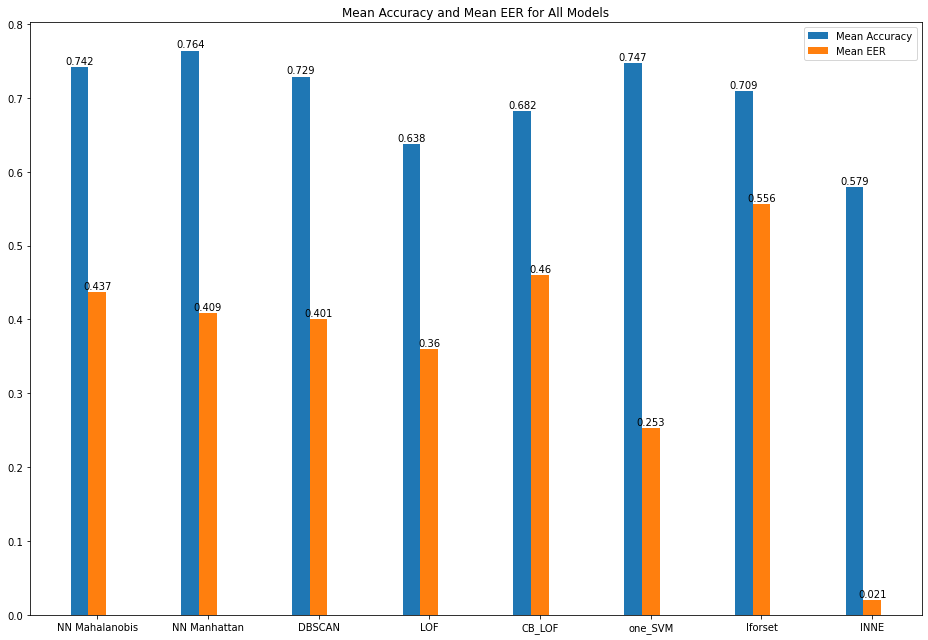

In [78]:


w=0.16
x=['NN Mahalanobis'  ,   'NN Manhattan' , 'DBSCAN' , 'LOF' ,  'CB_LOF' , 'one_SVM' , 'Iforset' , 'INNE' ]


mean =[  Mean_Accu_Neighbor_Mahalobis , Mean_Accu_Neighbor_Manhattan , Mean_Acc_DBSCAN , Mean_acc_LOF , Mean_Acc_CB_LOF , Mean_ِAccu_one_SVM , Mean_Acc_Iforset , Mean_Acc_INNE ]
eer =[   Mean_EER_Neighbor_Mahalobis ,  Mean_EER_Neighbor_Manhattan  , Mean_EER_DBSCAN , 0.36 , Mean_EER_CB_LOF , Mean_EER_one_SVM  , Mean_EER_Iforset , Mean_EER_INNE ]


bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]



plt.rcParams["figure.figsize"] = (13, 9)

bar11=plt.bar(bar1,mean,w,label='Mean Accuracy')
bar22=plt.bar(bar2,eer,w,label='Mean EER')


for rect in bar11 + bar22 :
    height = rect.get_height()
    height =float(f'{height:.3f}')
    if height > 0:
        plt.text(rect.get_x() + rect.get_width()/2.,
             1.002*height,'%s' % (height), ha='center', va='bottom') 

plt.xticks(bar2,x)
plt.title('Mean Accuracy and Mean EER for All Models')        
plt.legend()
plt.tight_layout()
plt.show( )  


In [79]:
ALL_Idx = []
ALL_Idx.append(svm_outlier_index[0]) 
ALL_Idx.append(dbsc_outlier_index[0])
ALL_Idx.append(LOF_outlier_index[0])
ALL_Idx.append(CB_LOF_outlier_index[0])
ALL_Idx.append(nb_h_outlier_index[0])
ALL_Idx.append(nb_m_outlier_index[0])
ALL_Idx.append(IForest_outlier_index[0])
ALL_Idx.append(iNNE_outlier_index[0])

In [80]:
AND_Vote_Index = list(set.intersection(*map(set,ALL_Idx)))

In [81]:
len(AND_Vote_Index)

0

In [82]:
AND_Vote_Index

[]

# Weighted Average Fusion

In [83]:
print(np.min(nb_h_scores))
print(np.max(nb_h_scores))
# Max is outlier

0.04338133239078763
35.6865723597826


In [84]:
print(np.min(nb_m_scores))
print(np.max(nb_m_scores))
# Max is outlier

0.18740000000000004
61.21379999999999


In [85]:
nb_m_scores[0]

array([[ 5.2135],
       [ 3.6807],
       [ 2.9085],
       [ 3.8559],
       [ 2.668 ],
       [ 2.1395],
       [ 1.9388],
       [ 1.6033],
       [ 1.4866],
       [ 1.6062],
       [ 2.0178],
       [ 2.0968],
       [ 1.9409],
       [ 2.7413],
       [ 4.9927],
       [ 1.314 ],
       [ 1.4766],
       [ 1.8037],
       [ 2.1762],
       [ 2.4523],
       [ 1.302 ],
       [ 1.0182],
       [ 1.3161],
       [ 1.5814],
       [ 2.2675],
       [ 3.3188],
       [ 1.8559],
       [ 1.1856],
       [ 1.8227],
       [ 1.0525],
       [ 1.6022],
       [ 1.7386],
       [ 0.9446],
       [ 2.3505],
       [ 1.4019],
       [ 1.9997],
       [ 2.3338],
       [ 1.7803],
       [ 1.1187],
       [ 1.5061],
       [ 0.9959],
       [ 1.7464],
       [ 1.0325],
       [ 3.2553],
       [ 1.9463],
       [ 1.1564],
       [ 2.7485],
       [ 1.5243],
       [ 1.1242],
       [ 2.55  ],
       [ 3.2611],
       [ 1.1555],
       [ 1.664 ],
       [ 0.9146],
       [ 0.8406],
       [ 1

In [86]:
print(np.min(LOF_scores))
print(np.max(LOF_scores))
# Min is outlier

-25.42924912416917
-0.9534596508246345


In [87]:
print(np.min(CB_LOF_scores))
print(np.max(CB_LOF_scores))
# Max is outlier

0.049348140660577085
35.28538572890734


In [88]:
print(np.min(IForest_scores))
print(np.max(IForest_scores))
# Min is an outlier

-0.6830310309689924
-0.40919954837082473


In [89]:
print(np.min(iNNE_scores))
print(np.max(iNNE_scores))
# Max is outlier

-0.04718797756818459
1.0


In [90]:
print(np.min(SVM_scores))
print(np.max(SVM_scores))
# Min is outlier

30.242449013783087
25021.26911595505


In [91]:
LOF_scores = np.array(LOF_scores) * -1
IForest_scores = np.array(IForest_scores) * -1
SVM_scores = np.array(SVM_scores) * -1

In [92]:
def normalize(m):
  for i in range(len(m)):
    for j in range(len(m[i])):
      m[i][j] = (m[i][j] - np.min(m[i])) / (np.max(m[i]) - np.min(m[i])) 
  return m
nb_h_scores = normalize(nb_h_scores)
nb_m_scores = normalize(nb_m_scores)
LOF_scores = normalize(LOF_scores)
SVM_scores = normalize(SVM_scores)
IForest_scores = normalize(IForest_scores)
iNNE_scores = normalize(iNNE_scores)
CB_LOF_scores = normalize(CB_LOF_scores)

In [100]:
import statistics

Weighted_Avg_Fusion = np.zeros(shape=(51,400))

for i in range(51):
  for j in range(400):
    x = []
    x.append(0.5 * np.array(nb_m_scores[i][j][0]))
    x.append(0.5 * np.array(SVM_scores[i][j]))
    Weighted_Avg_Fusion[i,j] = statistics.mean(x)    

In [101]:
avg_accuracies = []
avg_eers = []

for i in range(len(subjects)):
  genuine_df = df.loc[df.subject == subjects[i], "H.period":"H.Return"]
  imposter_df = df.loc[df.subject != subjects[i], :]
  
  genuine_df = genuine_df.reset_index()
  imposter_df = imposter_df.reset_index() 

 
  train = genuine_df[200:]
  train.drop('index', axis=1, inplace=True)


  # True set (200 records)
  test_genuine = genuine_df[:200]
  test_genuine = test_genuine.reset_index()

  test_genuine.drop('level_0', axis=1, inplace=True)
  test_genuine.drop('index', axis=1, inplace=True)
    
  # False set (200 records, 4 per imposter, 50 imposters in all)
  test_imposter = imposter_df.groupby("subject").head(4).loc[:, "H.period":"H.Return"]
  test_imposter = test_imposter.reset_index()
  test_imposter.drop('index', axis=1, inplace=True)

  data = test_genuine.append(test_imposter, ignore_index=True)

  y_true = [0]*200 + [-1]*200

  th=np.mean(Weighted_Avg_Fusion[i])
  outlier_index = np.where(Weighted_Avg_Fusion[i] >= th ) 
  outlier_values = data.iloc[outlier_index]

  y_pred = []
  for i in range(len(data)):
    if (i in outlier_index[0]):
      y_pred.append(-1)
    else:
      y_pred.append(0)
  
  avg_accuracies.append(accuracy_score(y_true, y_pred))

  fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label=0)
  fnr = 1 - tpr
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
  avg_eers.append(eer)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.p

In [102]:
avg_accuracies

[0.81,
 0.8425,
 0.81,
 0.8475,
 0.8475,
 0.7975,
 0.845,
 0.84,
 0.81,
 0.845,
 0.785,
 0.835,
 0.84,
 0.795,
 0.8775,
 0.6975,
 0.8025,
 0.8375,
 0.8075,
 0.8525,
 0.83,
 0.8125,
 0.8525,
 0.8275,
 0.805,
 0.7175,
 0.7775,
 0.75,
 0.79,
 0.7925,
 0.8625,
 0.7525,
 0.8025,
 0.7925,
 0.7275,
 0.85,
 0.8525,
 0.4475,
 0.81,
 0.74,
 0.7375,
 0.8125,
 0.5675,
 0.82,
 0.785,
 0.9225,
 0.805,
 0.8,
 0.84,
 0.76,
 0.8]

In [103]:
print( np.mean(avg_accuracies)  ) 

0.7974019607843138


In [104]:
print( np.mean( avg_eers ) )

0.31117647058823533


# **Classification**

In [23]:


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier




# **Classification Algorithms**

# **Building The Models**

In [24]:


KNN_model = make_pipeline (  StandardScaler( ) ,  KNeighborsClassifier(n_neighbors=1 )   ) 

SVM_Model = make_pipeline(  StandardScaler( )  ,  SVC(gamma='auto'))

RF_Model = make_pipeline(  StandardScaler( )  ,   RandomForestClassifier(   n_estimators=20, random_state=0   )    )

NN_Model = make_pipeline(  StandardScaler( )  ,    GaussianNB(   )   )

DT_Model = make_pipeline( StandardScaler( )  ,  DecisionTreeClassifier( criterion = "entropy",  max_depth = 2,  min_samples_split = 5, min_samples_leaf = 2, max_features = 2  )   ) 
 
 
Ensemble_hard = VotingClassifier(  estimators=[  ('SVM', SVM_Model ) , ('RF',  RF_Model )  ,  (  'KNN' , KNN_model  )   ] ,  voting='hard' , weights= [ 2 , 3 , 1  ]   )


In [25]:


def Compute_EER(   y_true ,   y_pred ):

  fpr, tpr, threshold = roc_curve(y_true , y_pred , pos_label = 0   )
  fnr = 1 - tpr
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

  return  eer ; 

 
 

In [97]:



KNN_accuracy_list = [ ]
SVM_accuracy_list = [ ]
RF_accuracy_list = [ ] 
NN_accuracy_list = [ ] 
DT_accuracy_list = [ ] 
Voting_accuracy_list = [  ] 



KNN_EER_list  =  [ ] 
SVM_EER_list =  [  ] 
RF_EER_list  = [  ] 
NN_EER_list  = [  ] 
DT_EER_list  = [  ] 
Voting_EER_list =  [  ] 



for subject in subjects:           
  # Consider current subject as genuine and rest as imposters
  # !!!!!!!!!!!!!!!!!!!!!!! to be seen the df  whether it will be 51 or not

  genuine_df = df.loc[df.subject == subject, "H.period":"H.Return"]
  imposter_df = df.loc[df.subject != subject, :]
  


  genuine_df = genuine_df.reset_index()
  imposter_df = imposter_df.reset_index() 

 
  train = genuine_df[:400]
  train.drop('index', axis=1, inplace=True)


  # # True set (100 records)
  # test_genuine = genuine_df[300:]
  # test_genuine = test_genuine.reset_index()

  # test_genuine.drop('level_0', axis=1, inplace=True)
  # test_genuine.drop('index', axis=1, inplace=True)
    
    

  # False set (250 records, 5 per imposter, 50 imposters in all)      
  test_imposter = imposter_df.groupby("subject").head( 8 ).loc[:, "H.period":"H.Return"]         ##  8 for each imposter  ===>>>>> 400
  test_imposter = test_imposter.reset_index()
  test_imposter.drop('index', axis=1, inplace=True)
 


  data = train.append( test_imposter , ignore_index=True)
 
  # y_true
  label = [0]*len( train ) + [-1]*len( test_imposter )

  x_train, x_test, y_train, y_test = train_test_split( data  ,  label ,  test_size=0.3 ,    random_state=0,  stratify= label  )


  KNN_model = KNN_model.fit(   x_train ,   y_train     )
  SVM_Model = SVM_Model.fit(     x_train ,   y_train   )
  RF_Model = RF_Model.fit(      x_train ,   y_train   )
  NN_Model = NN_Model.fit(    x_train ,   y_train  )
  DT_Model = DT_Model.fit(     x_train ,   y_train     )
###############################################################################
###############################################################################

 
  # Fit the model with voting classifier
  #
  Ensemble_hard.fit(    x_train ,   y_train  )


###############################################################################
###############################################################################


  KNN_pred = KNN_model.predict(  x_test )
  SVM_pred = SVM_Model.predict(  x_test ) 
  RF_pred  = RF_Model.predict(   x_test  )  
  NN_pred = NN_Model.predict(    x_test  ) 
  DT_pred = DT_Model.predict(    x_test  ) 

  Ensemble_hard_pred = Ensemble_hard.predict(  x_test   ) 


###############################################################################

  KNN_accuracy_list.append(  accuracy_score(  y_test  , KNN_pred   ) )
  SVM_accuracy_list.append(  accuracy_score(  y_test ,   SVM_pred   )  )
  RF_accuracy_list.append(  accuracy_score(  y_test ,   RF_pred   )  )
  NN_accuracy_list.append(  accuracy_score(  y_test ,   NN_pred   )  )
  DT_accuracy_list.append(  accuracy_score(  y_test ,   DT_pred   )  )
  Voting_accuracy_list.append(  accuracy_score(  y_test ,   Ensemble_hard_pred   )  )



  KNN_EER_list.append(   Compute_EER(  y_test  , KNN_pred )  )
  SVM_EER_list.append(  Compute_EER(  y_test  , SVM_pred ) )
  RF_EER_list.append(  Compute_EER(  y_test  , RF_pred ) )
  NN_EER_list.append(  Compute_EER(  y_test  , NN_pred ) )
  DT_EER_list.append(  Compute_EER(  y_test  , DT_pred ) )
  Voting_EER_list.append(  Compute_EER(  y_test  , Ensemble_hard_pred ) )



###############################################################################
###############################################################################

print( KNN_accuracy_list )
Mean_KNN_Acc = np.mean( KNN_accuracy_list )
Mean_KNN_EER =  np.mean( KNN_EER_list )
print ( "Mean KNN Accuracy && Mean EER   :- "  ,   Mean_KNN_Acc  , Mean_KNN_EER   )



print( SVM_accuracy_list )
Mean_SVM_Acc = np.mean( SVM_accuracy_list )
Mean_SVM_EER =  np.mean( SVM_EER_list )
print ( "Mean Accuracy && Mean EER   :- " ,  Mean_SVM_Acc   ,   Mean_SVM_EER  )



print( RF_accuracy_list )
Mean_RF_Acc =  np.mean( RF_accuracy_list )
Mean_RF_EER =  np.mean( RF_EER_list ) 
print ( "Mean Accuracy && Mean EER   :- " ,  Mean_RF_Acc  ,  Mean_RF_EER   )




print(  NN_accuracy_list )
Mean_NB_Acc =  np.mean( NN_accuracy_list )
Mean_NB_EER =  np.mean( NN_EER_list ) 
print ( "Mean Accuracy && Mean EER   :- " ,   Mean_NB_Acc  ,   Mean_NB_EER  )




print(  DT_accuracy_list )
Mean_DT_Acc =   np.mean( DT_accuracy_list )
Mean_DT_EER =   np.mean( DT_EER_list )  
print ( "Mean Accuracy && Mean EER   :- " , Mean_DT_Acc  ,  Mean_DT_EER )






print(  Voting_accuracy_list )
Mean_Stacking_Acc =   np.mean( Voting_accuracy_list ) 
Mean_Stacking_EER =    np.mean( Voting_EER_list ) 

print ( "Mean Accuracy && Mean EER   :- " ,  Mean_Stacking_Acc ,  Mean_Stacking_EER  )


# ###############################################################################
# ###############################################################################





#   nb_h_accuracies.append( accuracy_score( y_true, y_pred ) )
 
#   fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label=0)
#   fnr = 1 - tpr
#   eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
#   nb_h_eers.append(eer)


# print( nb_h_accuracies )




/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.p

[0.8875, 0.9666666666666667, 0.9583333333333334, 0.9583333333333334, 0.9166666666666666, 0.9458333333333333, 0.9333333333333333, 0.9833333333333333, 0.9666666666666667, 0.9708333333333333, 0.9291666666666667, 0.8875, 0.9791666666666666, 0.975, 0.9333333333333333, 0.9458333333333333, 0.8916666666666667, 0.9625, 0.9625, 0.9125, 0.9291666666666667, 0.9333333333333333, 0.9791666666666666, 0.9541666666666667, 0.9416666666666667, 0.8875, 0.925, 0.9583333333333334, 0.9541666666666667, 0.95, 0.975, 0.95, 0.95, 0.9416666666666667, 0.9458333333333333, 0.9583333333333334, 0.9625, 0.9708333333333333, 0.9458333333333333, 0.9041666666666667, 0.9208333333333333, 0.9375, 0.9458333333333333, 0.9583333333333334, 0.9458333333333333, 0.9791666666666666, 0.9958333333333333, 0.9208333333333333, 1.0, 0.9791666666666666, 0.95]
Mean KNN Accuracy && Mean EER   :-  0.9473856209150328 0.0772875816993464
[0.925, 0.9833333333333333, 0.9666666666666667, 0.9625, 0.9666666666666667, 0.95, 0.95, 0.9791666666666666, 0.9

# **Plotting Bar Chart for all Models**

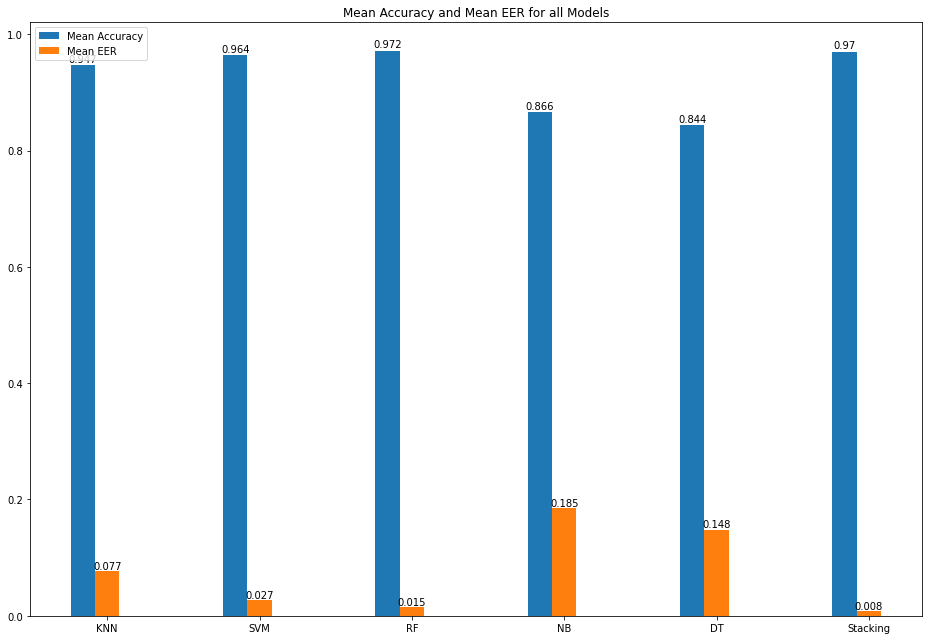

In [98]:




w=0.16
x=[ 'KNN'  ,   'SVM' , 'RF' , 'NB' ,  'DT' , 'Stacking'  ]


mean_acc =[  Mean_KNN_Acc , Mean_SVM_Acc , Mean_RF_Acc     , Mean_NB_Acc    , Mean_DT_Acc , Mean_Stacking_Acc  ]
mean_eer =[   Mean_KNN_EER ,  Mean_SVM_EER  , Mean_RF_EER ,  Mean_NB_EER    , Mean_DT_EER , Mean_Stacking_EER  ]


bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]



plt.rcParams["figure.figsize"] = (13, 9)

bar11=plt.bar(bar1,mean_acc,w,label='Mean Accuracy')
bar22=plt.bar(bar2,mean_eer,w,label='Mean EER')


for rect in bar11 + bar22 :
    height = rect.get_height()
    height =float(f'{height:.3f}')
    if height > 0:
        plt.text(rect.get_x() + rect.get_width()/2.,
             1.002*height,'%s' % (height), ha='center', va='bottom') 

plt.xticks(bar2,x)
plt.title('Mean Accuracy and Mean EER for all Models')        
plt.legend()
plt.tight_layout()
plt.show( )  


